In [1]:
#!pip install aeon==0.4.0 charset_normalizer==3.2.0 tensorflow==2.11.1
#!conda install -c conda-forge python-graphviz graphviz

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from tensorflow.compat.v1.keras.backend import get_session
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()


#os.environ["CUDA_VISIBLE_DEVICES"]="0" # second gpu
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    gpu_to_limit = gpus[0]  # or 1, watch out for CUDA_VISIBLE_DEVICES
    gpu_mem_mb = 24564  # tyle mamy
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    tf.config.set_logical_device_configuration(
        gpu_to_limit, [tf.config.LogicalDeviceConfiguration(memory_limit=gpu_mem_mb//2)]
    )
else:
    print('Working on CPU')

Instructions for updating:
non-resource variables are not supported in the long term
Working on CPU


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,MinMaxScaler
import shap
from sklearn.tree import DecisionTreeClassifier
from aeon.datasets import load_classification

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
# convlstm model
from numpy import mean
from numpy import std
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import ConvLSTM2D,ConvLSTM1D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import math

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor
 
def load_dataset_aeon(dsname):
    X, y,meta = load_classification(dsname)
    X = np.moveaxis(X,1,2)
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    trainX, testX, trainy, testy= train_test_split(X,y)
    
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy
 
# fit and evaluate a model
def train_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps/n_steps)
    #n_steps, n_length = 4, 32 #todo this has to be dividers of trainX.shape[1]
    #trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    #testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = Sequential()
    model.add(Reshape((n_steps, 1, n_length, n_features), input_shape=trainX.shape[1:]))
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten(name='embedding')) #is this a latent representation we could use for clustering?
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model

def generate_label_weights(train_y):
    # Count the occurrences of each class by summing across rows
    class_counts = np.sum(train_y, axis=0)

    # Calculate the total number of samples
    total_samples = np.sum(class_counts)

    # Calculate the weight for each class
    class_weights = {}
    num_classes = train_y.shape[1]
    for i in range(num_classes):
        class_weights[i] = total_samples / (num_classes * class_counts[i])

    return class_weights

def train_lstmconv_model(trainX, trainy, testX, testy, kernel=9):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps/n_steps)
    #n_steps, n_length = 4, 32 #todo this has to be dividers of trainX.shape[1]
    #trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    #testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    print(f'Input shape (time, rows, channels): {(n_steps, n_length, n_features)}')
    model = Sequential()
    model.add(Reshape((n_steps, n_length, n_features), input_shape=trainX.shape[1:]))
    model.add(ConvLSTM1D(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1, 
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(ConvLSTM1D(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1, 
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten(name='embedding')) #is this a latent representation we could use for clustering?
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

    print(model.summary())
    # fit network
    weights = generate_label_weights(trainy)
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,class_weight=weights)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def evaluate_model(dataset, repeats=1):
    # load data
    trainX, trainy, testX, testy = load_dataset_aeon(dataset)
    #fill missing with zeros
    trainX = np.nan_to_num(trainX, nan=0)
    testX = np.nan_to_num(testX, nan=0)
    
    scaler = StandardScaler()
    trainX = scaler.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX = scaler.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score,model = train_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return model, trainX, trainy, testX,testy,score

# run an experiment
def evaluate_lstmconv_model(dataset, repeats=1):
    # load data
    trainX, trainy, testX, testy = load_dataset_aeon(dataset)

    #fill missing with zeros
    trainX = np.nan_to_num(trainX, nan=0)
    testX = np.nan_to_num(testX, nan=0)
    
    scaler = StandardScaler()
    trainX = scaler.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX = scaler.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score,model = train_lstmconv_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    return model, trainX, trainy, testX,testy,score
 

In [6]:
import pickle
import os
import keras
def save_bundle(model, trainX,trainy,testX,testy,svtr,svts, dsname, dir='./results'):
    if not os.path.isdir(f'{dir}/{dsname}'):
        os.makedirs(f'{dir}/{dsname}')

    model.save(f'{dir}/{dsname}/model.h5',save_format='h5')
    pickle.dump(trainX, open(f'{dir}/{dsname}/trainX.pickle','wb'))
    pickle.dump(trainy, open(f'{dir}/{dsname}/trainy.pickle','wb'))
    pickle.dump(testX, open(f'{dir}/{dsname}/testX.pickle','wb'))
    pickle.dump(testy, open(f'{dir}/{dsname}/testy.pickle','wb'))
    pickle.dump(svtr, open(f'{dir}/{dsname}/svtr.pickle','wb'))
    pickle.dump(svts, open(f'{dir}/{dsname}/svts.pickle','wb'))

    
def load_bundle(dsname, dir='./results'):
    model = keras.models.load_model(f'{dir}/{dsname}/model.h5')
    
    trainX= pickle.load( open(f'{dir}/{dsname}/trainX.pickle','rb'))
    trainy = pickle.load(open(f'{dir}/{dsname}/trainy.pickle','rb'))
    testX= pickle.load(open(f'{dir}/{dsname}/testX.pickle','rb'))
    testy= pickle.load(open(f'{dir}/{dsname}/testy.pickle','rb'))
    svtr = pickle.load(open(f'{dir}/{dsname}/svtr.pickle','rb'))
    svts = pickle.load(open(f'{dir}/{dsname}/svts.pickle','rb'))

    return model, trainX,trainy,testX,testy,svtr,svts

In [7]:
import warnings
warnings.filterwarnings("ignore")

bg_size = 1000
window_len = 23
stride =10
shap_version = 'deep' #'window'
#limits due to memory limitations of GPUs
SEQUENCE_LENGTH_LIMIT=1000
DIMENSIONALITY_LIMIT=200
ACC_LIMIT=0
absshap=True

dataset='ECG200'

X, y,meta = load_classification(dataset)
X = np.moveaxis(X,1,2)
if X.shape[1] > SEQUENCE_LENGTH_LIMIT:
    print(f'Skipping: {dataset} due to sequence length')
if X.shape[2] > DIMENSIONALITY_LIMIT:
    print(f'Skipping: {dataset} due to dimensionality size')
print(f'Classifying: {dataset}')
model, trainX, trainy, testX,testy,score=evaluate_lstmconv_model(dataset)
if score < ACC_LIMIT:
    print(f'Skipping: {dataset} due to low score which is {score}')
print(f'Size of the problem: {trainX.shape}')
if shap_version == 'window':
    #There is a problem with Windowed version for more than two classes
    indexes = np.arange(0, len(trainX))
    np.random.shuffle(indexes)
    maxid = min(bg_size, len(trainX))
    background_data = trainX[indexes[:maxid]]
    
    sv_ts = np.zeros((len(testX),testX.shape[1], testX.shape[2]))
    sv_tr = np.zeros((len(trainX),trainX.shape[1], trainX.shape[2]))
    
    for i in range(len(testX)):
        gtw = SlidingWindowSHAP(model, stride, window_len, background_data, testX[i:i+1], model_type='lstm')
        sv_ts[i,:,:] = gtw.shap_values(num_output=trainy.shape[1])
    for i in range(len(trainX)):
        gtw = SlidingWindowSHAP(model, stride, window_len, background_data, trainX[i:i+1], model_type='lstm')
        sv_tr[i,:,:] = gtw.shap_values(num_output=trainy.shape[1])
elif shap_version == 'deep':
    indexes = np.arange(0, len(trainX))
    np.random.shuffle(indexes)
    maxid = min(bg_size, len(trainX))
    background_data = trainX[indexes[:maxid]]
    
    explainer = shap.DeepExplainer(model,background_data)
    shap_values_ts = explainer.shap_values(testX, check_additivity=False)
    shap_values_tr = explainer.shap_values(trainX, check_additivity=False)
    if absshap:
        sv_ts = abs(np.array(shap_values_ts)).mean(axis=0) # This basically returns the average importance over the feature/sample
                                           # Not taking into account the sign of shap value, as it is not required
                                           # for breakpoints calculation
        sv_tr = abs(np.array(shap_values_tr)).mean(axis=0) # This basically returns the average importance over the feature/sample
                                               # Not taking into account the sign of shap value, as it is not required
                                               # for breakpoints calculation
    else:
        indexer = np.argmax(model.predict(testX), axis=1)
        sv_ts=[]
        for i in range(0,len(testX)):
            sv_ts.append([shap_values_ts[indexer[i]][i,:]])
        sv_ts=np.concatenate(sv_ts)
        indexer = np.argmax(model.predict(trainX), axis=1)
        sv_tr=[]
        for i in range(0,len(trainX)):
            sv_tr.append([shap_values_tr[indexer[i]][i,:]])
        sv_tr=np.concatenate(sv_tr)
        
save_bundle(model, trainX,trainy,testX,testy,sv_tr,sv_ts, dataset,dir='./results/UCR-TEST')



   

Classifying: ECG200
Input shape (time, rows, channels): (3, 32, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 32, 1)          0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 3, 32, 64)         150016    
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 3, 32, 32)         110720    
                                                                 
 dropout (Dropout)           (None, 3, 32, 32)         0         
                                                                 
 embedding (Flatten)         (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                       

In [12]:
from tsproto.models import *
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [9]:
import numpy as np
# Set the global random seed
np.random.seed(42)

In [13]:
dataset='ECG200'

MAX_DEPTH=500

uw=False
c=3
f=0.1
af=np.mean
m=0


best_c=None
best_f=None
best_m = None
best_af=None
best_uw=None
met='sbc' #rocket|dtw|kmeans, etc.


model, trainXo,trainyo,testX,testy,trainsvo,testsv = load_bundle(dataset,dir='./results/UCR-TEST/')

print(f'Unique classes in saved bundle: {np.unique(trainyo)}')

trainX,valX,trainy,valy,trainsv,valsv = train_test_split(trainXo,trainyo,trainsvo,train_size=0.80,random_state=42)

pe = PrototypeEncoder(model,
                              n_clusters=c,#float(len(np.unique(np.argmax(model.predict(trainX),axis=1)))), #has no effect when sbc, or it can trigger pelt model to beb binary, and us eclusers to set number of breakpoints
                              min_size=max(3,int(f*trainX.shape[1])), 
                              dims=trainX.shape[2],
                              method=met, importance_aggregation_func=af,
                              global_breakpointing=True,
                              
                      jump=1, pen=1,multiplier=m,n_jobs=-1,descriptors=['stats'],
                      verbose=1,pelt_model='rbf')

im  = InterpretableModel()
ohe_train, features, target, weights = pe.fit_transform(trainX,trainsv)

acc,prec,rec,f1,iclf = im.fit_or_predict(ohe_train, features, target,# min_samples_leaf=0.05,
                                                   average='macro',
                                                   weights=weights if uw is True else None, 
                                                   max_depth=2)

ohe_test, features, target,weights = pe.transform(testX,testsv)
acc,prec,rec,f1,iclf = im.fit_or_predict(ohe_test,
                                               features, target,intclf=iclf, average='macro',
                                                  weights=weights if uw is True else None
                                                  )


print(f'Fidelity: \n\tACC:{acc}, \n\tPREC:{prec}, \n\tREC:{rec}, \n\tF1:{f1} \n Depth: {iclf.get_depth()}\n')  



Unique classes in saved bundle: [0. 1.]
Dataset shape: (120, 96, 1)
Calculating changepoints...
Done in 0.26352667808532715.
Clustering data
Shape of data for clustering: (600, 48, 1)
Clustering data
Done in 0.0009908676147460938.
OHE time series
['stats']
Done in 0.18939757347106934.
Dataset shape: (50, 96, 1)
Calculating changepoints...
Done in 0.038326263427734375.
Clustering data
Shape of data for clustering: (250, 48, 1)
Done in 0.1196889877319336.
OHE time series
['stats']
Done in 0.0939950942993164.
Fidelity: 
	ACC:0.86, 
	PREC:0.8793859649122806, 
	REC:0.8083778966131907, 
	F1:0.8300145701796988 
 Depth: 2



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TC: 50 over ccshap: 50
Number of clusters in opposite_class: [17] as opposed ot actual class [33]
TC: 40 over ccshap: 40
Number of clusters in opposite_class: [8] as opposed ot actual class [32]
Decision Tree exported to ECG200 with embedded histograms successfully.


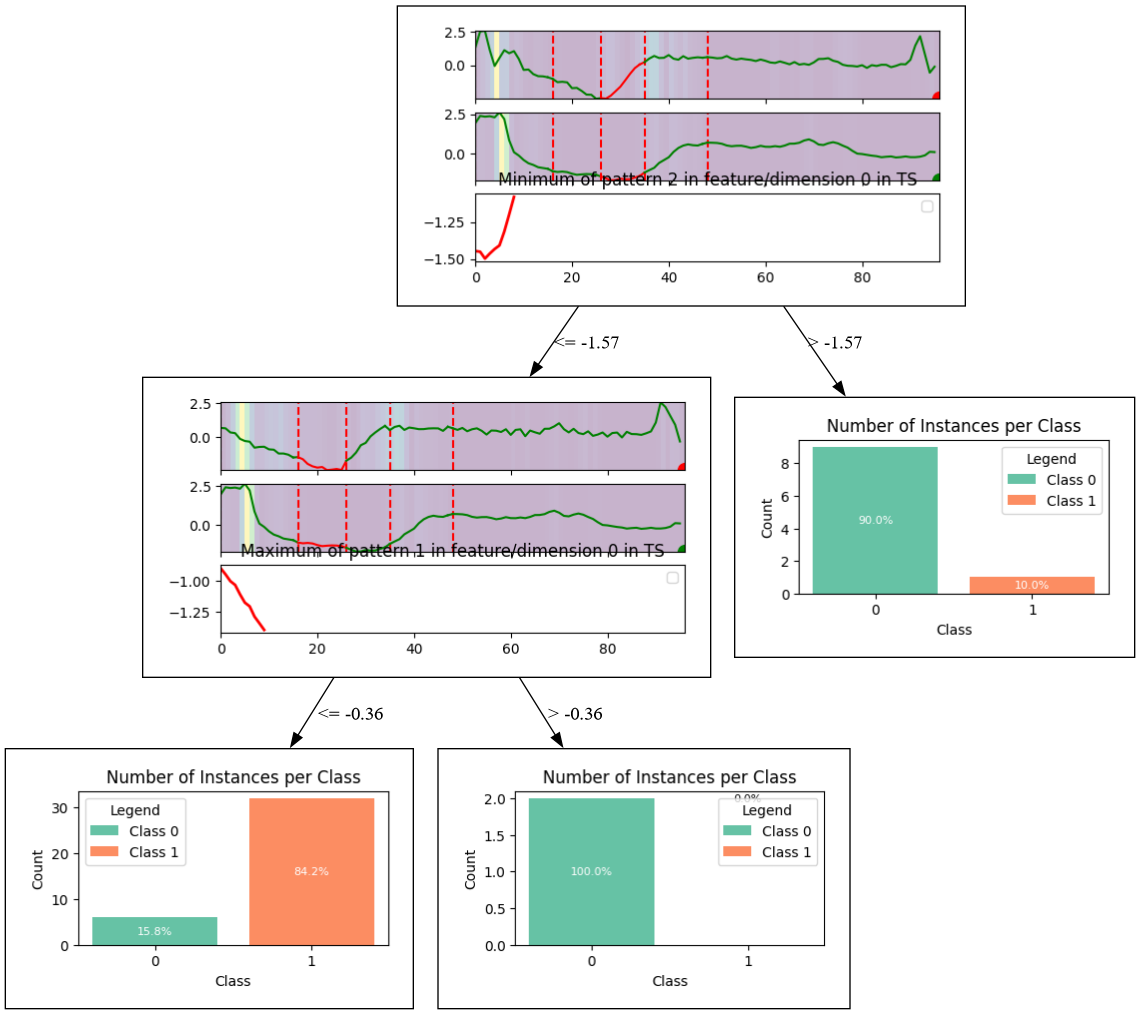

In [23]:
from  tsproto.plots import *

ds_final = ohe_test.copy()
dot = export_decision_tree_with_embedded_histograms(decision_tree=iclf,
                                              dataset=ds_final, 
                                              target_name='target', 
                                              feature_names=features, 
                                              filename=f'{dataset}',
                                              proto_encoder=pe, figsize=(6,3),focus_class=1, show_prototype=False)

from IPython.display import SVG, Image
Image(f'{dataset}.png')